# Comparison of data


by soniame@iadb.org

- **IDB COVID Impact Dashboard**

Database: `spd_sdv_waze_corona.prod_daily_daily_index`


- **Google COVID-19 Mobility Report**

CSV: [Google link](https://www.google.com/covid19/mobility/)

Baseline: median value for the corresponding day of week during a 5 week period from January 3rd, 2020 to February 6th, 2020. 

- **Waze driven kilometers** driven kilometers percent change from baseline. 

CSV: [Waze link](https://www.waze.com/covid19)

Baseline: average value for the corresponding day of week during a 2 week period from February 11th, 2020 to February 25th, 2020.

In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

In [2]:
from src import utils
from datetime import datetime
conn = utils.connect_athena(path='../configs/athena.yaml')

In [3]:
iso_codes = pd.read_sql_query("""
select 
    distinct country_iso_code, country_name
from spd_sdv_waze_corona.prod_daily_daily_index
""", conn)

In [4]:
len(iso_codes.country_iso_code.to_list())

20

In [5]:
iso_codes.sort_values('country_iso_code')

,country_iso_code,country_name
15,AR,Argentina
7,BB,Barbados
12,BO,Bolivia
0,BR,Brazil
1,CL,Chile
17,CO,Colombia
8,CR,Costa Rica
9,DO,Dominican Republic
16,EC,Ecuador
18,GT,Guatemala


## Country level

### Load data (country level)

Loading data for latinamerican countries. 

#### Waze dashboard

In [6]:
df_dash = pd.read_sql_query("""
select 
    *,
    (date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e')) as date
from spd_sdv_waze_corona.prod_daily_daily_index
where region_slug like '%country%'
""", conn)
# Bolivia

In [7]:
tab = (df_dash 
 >> group_by('country_iso_code', 'country_name', 'region_slug')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
#tab.to_csv('~/private/projects/google_mob_country_list.csv')
tab

,country_iso_code,country_name,region_slug,min_date,max_date,n_obs
0,AR,Argentina,country_argentina,2020-03-09,2021-03-01,358
1,BB,Barbados,country_barbados,2020-03-09,2021-03-01,358
2,BR,Brazil,country_brazil,2020-03-09,2021-03-01,358
3,CL,Chile,country_chile,2020-03-09,2021-03-01,358
4,CO,Colombia,country_colombia,2020-03-09,2021-03-01,358
5,CR,Costa Rica,country_costa_rica,2020-03-09,2021-03-01,358
6,DO,Dominican Republic,country_dominican_republic,2020-03-09,2021-03-01,358
7,EC,Ecuador,country_ecuador,2020-03-09,2021-03-01,358
8,GT,Guatemala,country_guatemala,2020-03-09,2021-03-01,358
9,HN,Honduras,country_honduras,2020-03-09,2021-03-01,358


In [8]:
print(len(iso_codes.country_iso_code.to_list()))
#df_dash.head()
print(len(df_dash.country_iso_code.unique())) # Bolivia is missing
df_dash.sort_values('country_iso_code').country_iso_code.unique()

20
19


array(['AR', 'BB', 'BR', 'CL', 'CO', 'CR', 'DO', 'EC', 'GT', 'HN', 'JM',
       'MX', 'NI', 'PA', 'PE', 'PY', 'SV', 'TT', 'UY'], dtype=object)

In [9]:
len(df_dash.country_name.unique())
df_dash.country_name.unique()

array(['Peru', 'Nicaragua', 'Barbados', 'Chile', 'Brazil', 'Argentina',
       'Mexico', 'Honduras', 'Dominican Republic', 'Paraguay', 'Jamaica',
       'Panama', 'Ecuador', 'El Salvador', 'Colombia', 'Uruguay',
       'Costa Rica', 'Guatemala', 'Trinidad and Tobago'], dtype=object)

In [10]:
#df_dash.columns.tolist()


#### Waze driven km

In [11]:
df_waze = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/Waze _ COVID-19 Impact Dashboard_Country-Level Data_Table.csv")
df_waze.columns = ['date', 'country', 'pc_driven_miles']
df_waze['date'] = df_waze.date.apply(lambda x : datetime.strptime(x, '%b %d, %Y'))
df_waze['exists'] = df_waze.country.isin([ 'Argentina','Brazil', 'Chile', 'Colombia', 'Costa Rica',  
                                          'Ecuador', 'Guatemala',  'Mexico',  'Peru', 'Uruguay']) 
df_waze = df_waze.siu_filter(_.exists).siu_mutate(pc_driven_miles=100*_.pc_driven_miles)      

df_waze.head()

,date,country,pc_driven_miles,exists
1,2021-02-17,Peru,-44.0,True
9,2021-02-17,Mexico,-32.0,True
14,2021-02-17,Ecuador,-25.0,True
25,2021-02-17,Guatemala,-15.0,True
26,2021-02-17,Colombia,-12.0,True


Missing countries: Panama, Honduras, Trinidad and Tobago, Dominican Republic, Paraguay, Barbados, El Salvador, Jamaica, Nicaragua

In [12]:
tab = (df_waze 
 >> group_by('country')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
#tab.to_csv('~/private/projects/google_mob_country_list.csv')
tab

,country,min_date,max_date,n_obs
0,Argentina,2020-03-01,2021-02-17,354
1,Brazil,2020-03-01,2021-02-17,354
2,Chile,2020-03-01,2021-02-17,354
3,Colombia,2020-03-01,2021-02-17,354
4,Costa Rica,2020-03-01,2021-02-17,354
5,Ecuador,2020-03-01,2021-02-17,354
6,Guatemala,2020-03-01,2021-02-17,354
7,Mexico,2020-03-01,2021-02-17,354
8,Peru,2020-03-01,2021-02-17,354
9,Uruguay,2020-03-01,2021-02-17,354


In [13]:
print('Countries: ' + str(len(df_waze.country.unique())) )
df_waze.country.unique()

Countries: 10


array(['Peru', 'Mexico', 'Ecuador', 'Guatemala', 'Colombia', 'Costa Rica',
       'Chile', 'Brazil', 'Argentina', 'Uruguay'], dtype=object)

#### Google mobility

In [14]:
df_goo = pd.read_csv("~/shared/spd-sdv-omitnik-waze/corona/mobility/Global_Mobility_Report.csv")  
df_goo['inregion']=df_goo.country_region_code.isin(iso_codes.country_iso_code.to_list())
df_goo['date'] = df_goo.date.apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
df_goo = df_goo \
    .siu_filter(_.inregion) \
    .siu_filter( _.sub_region_1.isnull(), _.metro_area.isnull())
print(df_goo.shape)

(7211, 15)


In [15]:
tab = (df_goo 
 >> group_by('country_region_code', 'country_region')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
tab

,country_region_code,country_region,min_date,max_date,n_obs
0,AR,Argentina,2020-02-15,2021-02-09,361
1,BB,Barbados,2020-02-15,2021-02-09,361
2,BO,Bolivia,2020-02-15,2021-02-09,361
3,BR,Brazil,2020-02-15,2021-02-09,361
4,CL,Chile,2020-02-15,2021-01-31,352
5,CO,Colombia,2020-02-15,2021-02-09,361
6,CR,Costa Rica,2020-02-15,2021-02-09,361
7,DO,Dominican Republic,2020-02-15,2021-02-09,361
8,EC,Ecuador,2020-02-15,2021-02-09,361
9,GT,Guatemala,2020-02-15,2021-02-09,361


In [16]:
print(len(df_goo.country_region_code.unique()))
df_goo.country_region_code.unique()

20


array(['AR', 'BB', 'BO', 'BR', 'CL', 'CO', 'CR', 'DO', 'EC', 'GT', 'HN',
       'JM', 'MX', 'NI', 'PA', 'PE', 'PY', 'SV', 'TT', 'UY'], dtype=object)

In [17]:
df_goo.dtypes
df_goo.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'inregion'],
      dtype='object')

In [18]:
#df_dash.add_suffix('_col').head()

### Comparison

In [19]:
df = (df_dash \
     .siu_select('region_slug', 'country_name', 'country_iso_code', 'date', 'tcp') 
 >> left_join(_, 
          df_waze \
              .siu_select('country', 'date', 'pc_driven_miles') \
              .siu_rename(country_name='country'), 
              on=['country_name', 'date']) 
 >> left_join(_, 
          df_goo \
              .siu_select('country_region_code', 'date', 'transit_stations_percent_change_from_baseline') \
              .siu_rename(country_iso_code='country_region_code',
                          transit='transit_stations_percent_change_from_baseline'), 
              on=['country_iso_code', 'date']) 
 >> gather('measure', 'value', _["tcp":"transit"]) 
)
df.dtypes
df.head(2)

,region_slug,country_name,country_iso_code,date,measure,value
0,country_peru,Peru,PE,2021-02-12,tcp,-47.910036
1,country_peru,Peru,PE,2020-08-28,tcp,-30.997605


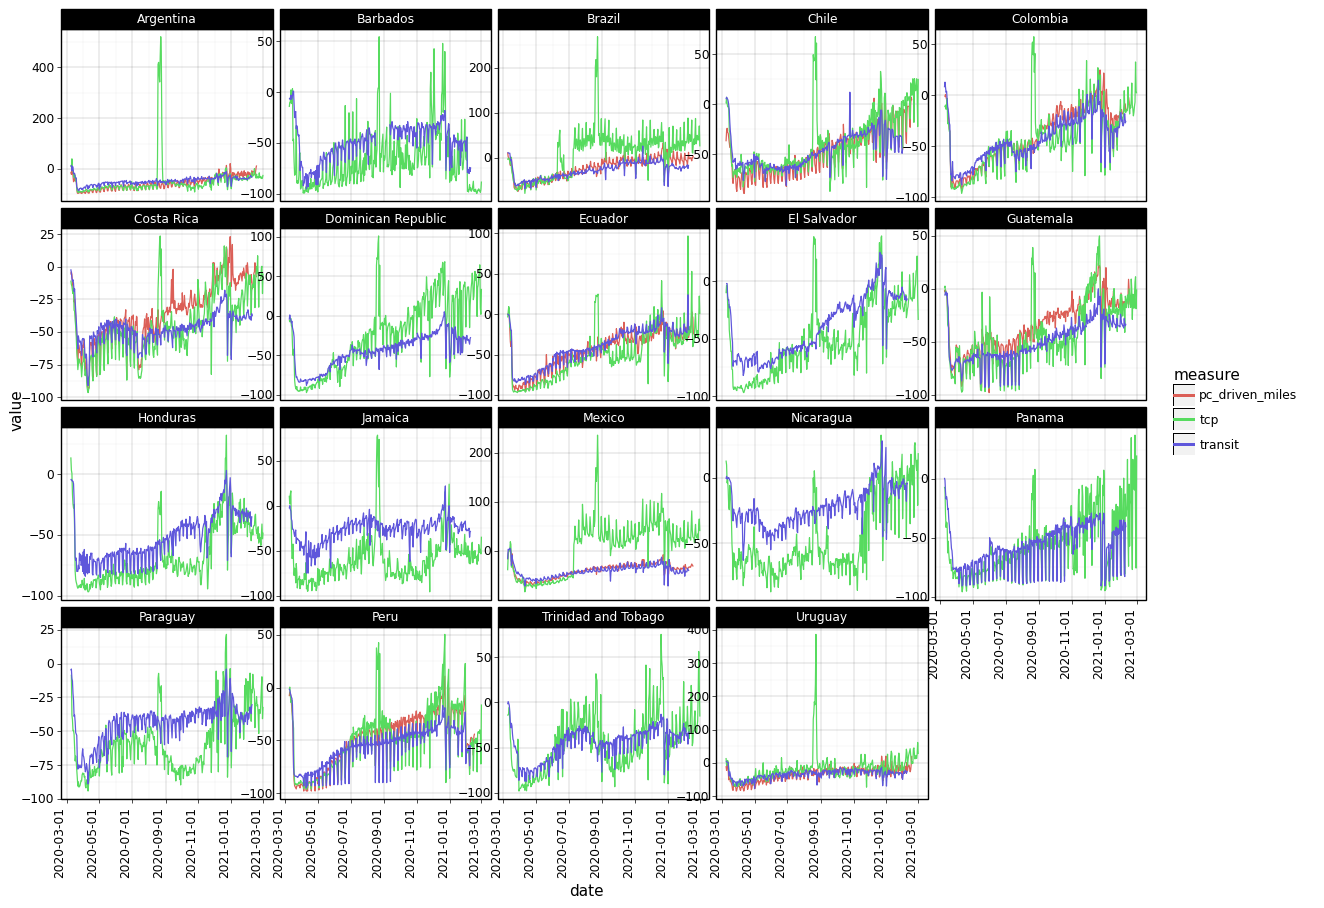

<ggplot: (8774472204961)>

In [20]:

(p9.ggplot(df, 
           p9.aes(x='date', y ='value', color = 'measure')) 
 + p9.geom_line()
 + p9.facet_wrap('country_name', scales='free_y') 
 + p9.theme(figure_size = (14, 10),
            axis_text_x=p9.element_text(rotation=90, hjust=1))
) 

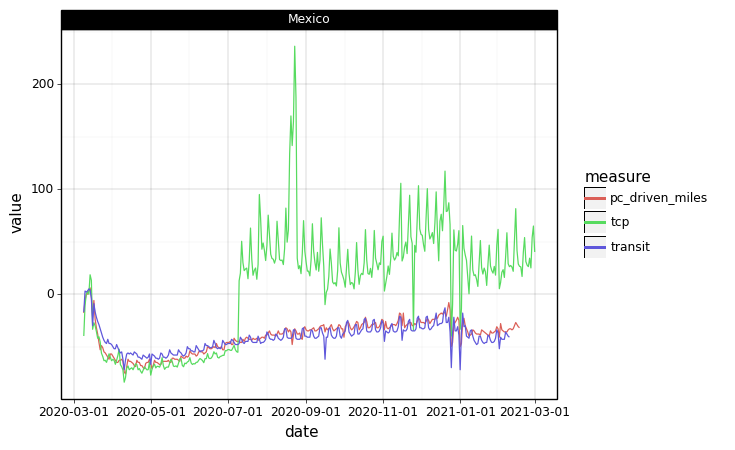

<ggplot: (8774472626313)>

In [21]:
(p9.ggplot(df.siu_filter(_.country_name=='Mexico'), 
           p9.aes(x='date', y ='value', color = 'measure')) 
 + p9.geom_line()
 + p9.facet_wrap('country_name')
) 

### Plots per data source

In [22]:
df_goo[['date', 'transit_stations_percent_change_from_baseline', 'country_region']] \
    .pivot(index='date', columns='country_region', values='transit_stations_percent_change_from_baseline') \
    .iplot(
    #theme='custom',
    yTitle='% Change',
    title='Google mobility - PC Transit stations'
)

In [23]:
df_dash[['date', 'tcp', 'region_slug']] \
    .pivot(index='date', columns='region_slug', values='tcp') \
    .iplot(
    #theme='custom',
    yTitle='% Change',
    title='Waze IDB dashboard - TCP'
)

In [24]:
df_waze[['date', 'pc_driven_miles', 'country']] \
    .pivot(index='date', columns='country', values='pc_driven_miles') \
    .iplot(
    #theme='custom',
    yTitle='% Change',
    title='Waze public - PC driven miles'
)

## City level

### Load data (city level)

In [25]:
cities_names = (pd.read_csv('../docs/city_names_dictionary.csv') 
    >> filter(_.country_iso_code__dash.isnull() == False)
)
cities_names.head(2)

,country_iso_code__dash,country_name__dash,region_slug__dash,region_name__dash,country__waze,city__waze,country_region_code__goo,country_region__goo,sub_region_1__goo,sub_region_2__goo
0,AR,Argentina,buenosaires,Buenos Aires,Argentina,Buenos Aires,AR,Argentina,Buenos Aires,None
1,AR,Argentina,cordoba,Córdoba,NaN,NaN,AR,Argentina,Cordoba,None


#### Waze dashboard

In [26]:
df_dash = pd.read_sql_query("""
select 
    *,
    (date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e')) as date
from spd_sdv_waze_corona.prod_daily_daily_index
where region_type = 'city';
""", conn)

In [27]:
df_dash.shape

(22196, 20)

In [28]:
tab = (df_dash 
 >> group_by('country_iso_code', 'country_name', 'region_slug', 'region_name')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
tab.to_csv('~/private/projects/dash_mob_city_list.csv')
tab

,country_iso_code,country_name,region_slug,region_name,min_date,max_date,n_obs
0,AR,Argentina,buenosaires,Buenos Aires,2020-03-09,2021-03-01,358
1,AR,Argentina,cordoba,Córdoba,2020-03-09,2021-03-01,358
2,AR,Argentina,rosario,Rosario,2020-03-09,2021-03-01,358
3,BO,Bolivia,santacruzdelasierra,Santa Cruz de la Sierra,2020-03-09,2021-03-01,358
4,BR,Brazil,belem,Belém,2020-03-09,2021-03-01,358
...,...,...,...,...,...,...,...
57,PA,Panama,panamacity,Ciudad de Panamá,2020-03-09,2021-03-01,358
58,PE,Peru,arequipa,Arequipa,2020-03-09,2021-03-01,358
59,PE,Peru,lima,Lima,2020-03-09,2021-03-01,358
60,SV,El Salvador,sansalvador,San Salvador,2020-03-09,2021-03-01,358


In [29]:
print(len(df_dash.region_name.unique())) # Bolivia is missing
df_dash.sort_values('region_name').region_name.unique()
df_dash.sort_values('region_slug').region_slug.unique()

62


array(['aguascalientes', 'arequipa', 'barranquilla', 'belem',
       'belohorizonte', 'bogota', 'brasilia', 'bucaramanga',
       'buenosaires', 'cali', 'campinas', 'cartagena', 'cordoba',
       'cucuta', 'cuenca', 'curitiba', 'fortaleza', 'goiania',
       'guadalajara', 'guatemala', 'guayaquil', 'joaopessoa', 'kingston',
       'leon', 'lima', 'maceio', 'managua', 'manaus', 'medellin',
       'merida', 'mexicocity', 'monterrey', 'montevideo', 'natal',
       'panamacity', 'pereira', 'porto_alergre', 'pueble', 'queretaro',
       'quito', 'recife', 'riodejaneiro', 'rosario', 'salvador',
       'sanjose', 'sanluispotosi', 'sansalvador', 'santacruzdelasierra',
       'santamarta', 'santiago', 'santiagocaballeros', 'santodomingo',
       'santos', 'saojosedoscampos', 'saoluis', 'saopaulo', 'sorocaba',
       'tegucigalpa', 'teresina', 'toluca', 'torreon', 'vitoria'],
      dtype=object)

#### Waze driven km

In [30]:
df_waze = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/Waze _ COVID-19 Impact Dashboard_City-Level Data_Table.csv")
df_waze.sort_values('Country').Country.unique()


array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Canada', 'Chile',
       'Colombia', 'Costa Rica', 'Czechia', 'Ecuador', 'France',
       'Germany', 'Hungary', 'Indonesia', 'Israel', 'Italy', 'Latvia',
       'Lithuania', 'Malaysia', 'Mexico', 'Netherlands', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania',
       'Singapore', 'Slovakia', 'South Africa', 'Spain', 'Sweden',
       'Ukraine', 'United Kingdom', 'United States', 'Uruguay'],
      dtype=object)

In [31]:
df_waze = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/Waze _ COVID-19 Impact Dashboard_City-Level Data_Table.csv")
df_waze.columns = ['date', 'city', 'country', 'pc_driven_miles']
df_waze['date'] = df_waze.date.apply(lambda x : datetime.strptime(x, '%b %d, %Y'))
df_waze['exists'] = df_waze.country.isin([ 'Argentina','Brazil', 'Chile', 'Colombia', 'Costa Rica',  
                                          'Ecuador', 'Guatemala',  'Mexico',  'Peru', 'Uruguay']) 
df_waze = df_waze.siu_filter(_.exists).siu_mutate(pc_driven_miles=100*_.pc_driven_miles)      

#df_waze.head()

In [32]:
tab = (df_waze 
 >> group_by('country', 'city')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
tab.to_csv('~/private/projects/waze_mob_city_list.csv')
tab

,country,city,min_date,max_date,n_obs
0,Argentina,Buenos Aires,2020-03-01,2021-02-17,354
1,Brazil,Belo Horizonte,2020-03-01,2021-02-17,354
2,Brazil,Brasilia,2020-03-01,2021-02-17,354
3,Brazil,Curitiba,2020-03-01,2021-02-17,354
4,Brazil,Florianopolis,2020-03-01,2021-02-17,354
5,Brazil,Fortaleza,2020-03-01,2021-02-17,354
6,Brazil,Guarulhos,2020-03-01,2021-02-17,354
7,Brazil,Porto Alegre,2020-03-01,2021-02-17,354
8,Brazil,Recife,2020-03-01,2021-02-17,354
9,Brazil,Rio De Janeiro,2020-03-01,2021-02-17,354


In [33]:
print(len(df_waze.city.unique())) # Bolivia is missing
df_waze.sort_values('city').city.unique()


29


array(['Belo Horizonte', 'Bogota', 'Brasilia', 'Buenos Aires', 'Cali',
       'Curitiba', 'Florianopolis', 'Fortaleza', 'Guadalajara',
       'Guarulhos', 'Las Condes', 'Lima', 'Maipu', 'Medellin',
       'Mexico City', 'Monterrey', 'Montevideo', 'Porto Alegre',
       'Puebla City', 'Quito', 'Recife', 'Rio De Janeiro', 'Salvador',
       'San Jose', 'Santiago', 'Santiago De Queretaro', 'Sao Paulo',
       'Vitoria', 'Zapopan'], dtype=object)

#### Google mobility

In [34]:
df_goo = pd.read_csv("~/shared/spd-sdv-omitnik-waze/corona/mobility/Global_Mobility_Report.csv")  


In [35]:
df_goo['inregion']=df_goo.country_region_code.isin(iso_codes.country_iso_code.to_list())
df_goo['date'] = df_goo.date.apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
df_goo = df_goo \
    .siu_filter(_.inregion) \
    .siu_filter( _.sub_region_1.isnull()==False)#, _.metro_area.isnull())
df_goo.sub_region_2=df_goo.sub_region_2.fillna('None')
df_goo.metro_area=df_goo.metro_area.fillna('None')
print(df_goo.shape)

(1180788, 15)


In [36]:
df_goo.head(2)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,inregion
7072,AR,Argentina,Buenos Aires,None,None,AR-C,NaN,2020-02-15,6.0,1.0,6.0,9.0,-2.0,0.0,True
7073,AR,Argentina,Buenos Aires,None,None,AR-C,NaN,2020-02-16,2.0,-2.0,-15.0,3.0,-9.0,2.0,True


In [37]:
tab = (df_goo 
 >> group_by('country_region_code', 'country_region', 'sub_region_1', 'sub_region_2', 'metro_area')
 >> summarize(min_date = _.date.min(),
             max_date = _.date.max(),
             n_obs = _.date.count())
 >> ungroup()
)
tab.to_csv('~/private/projects/google_mob_city_list.csv')
tab

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,min_date,max_date,n_obs
0,AR,Argentina,Buenos Aires,Comuna 1,None,2020-02-15,2021-02-09,361
1,AR,Argentina,Buenos Aires,Comuna 10,None,2020-02-15,2021-02-09,361
2,AR,Argentina,Buenos Aires,Comuna 11,None,2020-02-15,2021-02-09,361
3,AR,Argentina,Buenos Aires,Comuna 12,None,2020-02-15,2021-02-09,361
4,AR,Argentina,Buenos Aires,Comuna 13,None,2020-02-15,2021-02-09,361
...,...,...,...,...,...,...,...,...
3852,UY,Uruguay,Salto Department,None,None,2020-02-15,2021-02-09,358
3853,UY,Uruguay,San José Department,None,None,2020-02-15,2021-02-09,358
3854,UY,Uruguay,Soriano Department,None,None,2020-02-15,2021-02-09,354
3855,UY,Uruguay,Tacuarembó Department,None,None,2020-02-15,2021-02-09,354


In [38]:
tab.shape

(3857, 8)

### Comparison

In [39]:
df_goo.head(1)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,inregion
7072,AR,Argentina,Buenos Aires,None,None,AR-C,NaN,2020-02-15,6.0,1.0,6.0,9.0,-2.0,0.0,True


In [40]:
df=df_dash \
.siu_select('country_iso_code', 'country_name', 'region_slug', 'region_name', 'date', 'tcp') \
.add_suffix('__dash') \
.merge(cities_names, how='inner') \
.merge(df_waze.add_suffix('__waze'), 
       how='left', 
       left_on=['country__waze','city__waze', 'date__dash'],
       right_on = ['country__waze','city__waze', 'date__waze']) \
.merge(df_goo.add_suffix('__goo'), 
       how='left', 
       left_on=['country_region_code__goo','country_region__goo', 
                'sub_region_1__goo', 'sub_region_2__goo', 'date__dash'],
       right_on =['country_region_code__goo','country_region__goo', 
               'sub_region_1__goo', 'sub_region_2__goo', 'date__goo']) \
.siu_rename(transit__goo='transit_stations_percent_change_from_baseline__goo',
           workplace__goo='workplaces_percent_change_from_baseline__goo') \
.siu_select('country_iso_code__dash', 'country_name__dash', 'region_slug__dash', 
        'date__dash', 'tcp__dash', 'pc_driven_miles__waze',
           'transit__goo', 'workplace__goo') \
.siu_gather('measure', 'value', _["tcp__dash":"workplace__goo"]) 



In [46]:
print(df_dash.shape)
print(df_waze.shape)
print(df_goo.shape)
print(df.shape)
df.country_iso_code__dash.unique()

(22196, 20)
(10264, 5)
(1180788, 15)
(88784, 6)


array(['BR', 'EC', 'AR', 'CO', 'CL', 'JM', 'PE', 'DO', 'MX', 'NI', 'PA',
       'GT', 'UY', 'HN', 'CR', 'SV', 'BO'], dtype=object)

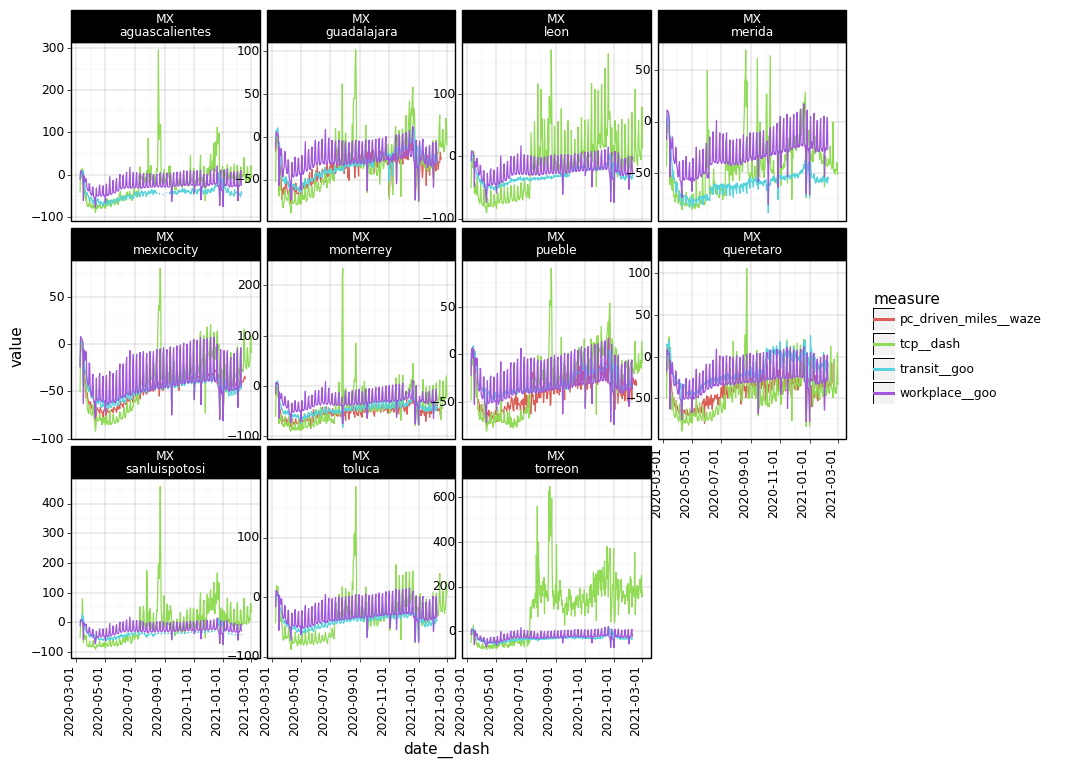

<ggplot: (8774459809421)>

In [48]:
(p9.ggplot(df.siu_filter(_.country_iso_code__dash == 'MX'), 
           p9.aes(x='date__dash', y ='value', color = 'measure')) 
 + p9.geom_line()
 + p9.facet_wrap(['country_iso_code__dash', 'region_slug__dash'], scales='free_y') 
 + p9.theme(figure_size = (10, 8),
            axis_text_x=p9.element_text(rotation=90, hjust=1))
) 